### Import Libraries

In [1]:
import sqlite3
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import scipy.stats as stats # type: ignore
from scipy.stats import ttest_ind #type: ignore
from sklearn.linear_model import LinearRegression # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from statsmodels.tsa.stattools import grangercausalitytests, adfuller # type: ignore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # type: ignore

### Stablish Connection with SQLite Database & Load Data from it

In [2]:
conn = sqlite3.connect('/home/jovyan/work/Test/data/CombinedDataset.sqlite')

In [3]:
solar_flare_df = pd.read_sql("SELECT * FROM Solar_Flare_Data", conn)
co2_concentration_df = pd.read_sql("SELECT * FROM Co2_Concentration_Data", conn)
temperature_change_df = pd.read_sql("SELECT * FROM Temperature_Data", conn)

In [4]:
# Close the connection
conn.close()

### Perform Some Addition Processing

In [5]:
# Data preprocessing
co2_concentration_df['Date'] = pd.to_datetime(co2_concentration_df['Date'])
solar_flare_df['Date'] = pd.to_datetime(solar_flare_df['Date'])
temperature_change_df['Date'] = pd.to_datetime(temperature_change_df['Date'])

solar_flare_df = solar_flare_df.dropna()
solar_flare_df = solar_flare_df.loc[:, ~solar_flare_df.columns.str.contains('^Unnamed')]
co2_concentration_df = co2_concentration_df.dropna()
temperature_change_df = temperature_change_df.dropna()

### Identify the date range of the Solar Flare dataset

In [6]:
start_date = solar_flare_df['Date'].min()
end_date = solar_flare_df['Date'].max()


start_date, end_date

(Timestamp('2010-05-01 23:48:00'), Timestamp('2019-12-31 10:00:00'))

### Filter the other datasets to match this date range

In [7]:
co2_data_filtered = co2_concentration_df[(co2_concentration_df['Date'] >= start_date) & (co2_concentration_df['Date'] <= end_date)]
temperature_data_filtered = temperature_change_df[(temperature_change_df['Date'] >= start_date) & (temperature_change_df['Date'] <= end_date)]


### Merge data on Date and Plot the merged data

In [8]:
# Merge data on Date
merged_data = pd.merge_asof(co2_data_filtered.sort_values('Date'), solar_flare_df.sort_values('Date'), on='Date')
merged_data = pd.merge_asof(merged_data, temperature_data_filtered.sort_values('Date'), on='Date')
# Set Date as index
merged_data.set_index('Date', inplace=True)
# Drop rows with missing values in the target variable 
merged_data.dropna(subset=['CO2_Concentration_PPM', 'Temp_change'], inplace=True)


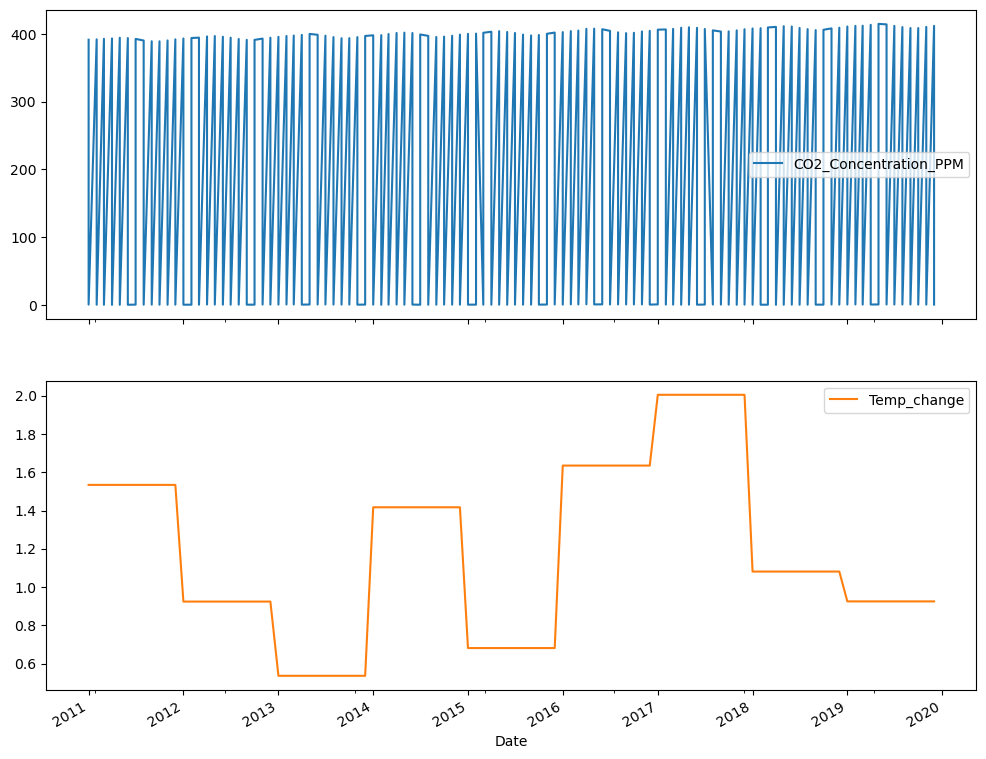

In [9]:
merged_data[['CO2_Concentration_PPM', 'Temp_change']].plot(subplots=True, figsize=(12, 10))
plt.show()

### Prepare and Normalize Data for Feature Selection based on their importance

In [10]:
# Prepare the data
X = merged_data[['FlareNumber', 'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX']]
y_co2 = merged_data['CO2_Concentration_PPM']
y_temp = merged_data['Temp_change']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the features and target variables
X_normalized = scaler.fit_transform(X)
y_co2_normalized = scaler.fit_transform(y_co2.values.reshape(-1, 1))
y_temp_normalized = scaler.fit_transform(y_temp.values.reshape(-1, 1))

X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)
y_co2_normalized_df = pd.DataFrame(y_co2_normalized, columns=['CO2_Concentration_PPM'])
y_temp_normalized_df = pd.DataFrame(y_temp_normalized, columns=['Temp_change'])

### Train a Random Forest Regressor Model for calculating Feature Importance

In [11]:
# Train the Random Forest model
model_rf_co2 = RandomForestRegressor().fit(X_normalized_df, y_co2_normalized_df)
model_rf_temp = RandomForestRegressor().fit(X_normalized_df, y_temp_normalized_df)

# Feature importance
importance_co2 = model_rf_co2.feature_importances_
importance_temp = model_rf_temp.feature_importances_

# Create a DataFrame for feature importance
feature_names = X_normalized_df.columns
importance_df_co2 = pd.DataFrame({'Feature': feature_names, 'Importance': importance_co2}).sort_values(by='Importance', ascending=False)
importance_df_temp = pd.DataFrame({'Feature': feature_names, 'Importance': importance_temp}).sort_values(by='Importance', ascending=False)

print("Feature Importance for CO2 Concentration:")
print(importance_df_co2)

print("Feature Importance for Temperature Change:")
print(importance_df_temp)


Feature Importance for CO2 Concentration:
       Feature  Importance
5      ABSNJZH    0.196164
6      SAVNCPP    0.182388
3       TOTPOT    0.153819
2       TOTBSQ    0.148751
7       USFLUX    0.137574
1      TOTUSJH    0.091338
4      TOTUSJZ    0.089967
0  FlareNumber    0.000000
Feature Importance for Temperature Change:
       Feature  Importance
6      SAVNCPP    0.209598
5      ABSNJZH    0.188729
7       USFLUX    0.162222
2       TOTBSQ    0.121292
3       TOTPOT    0.113266
4      TOTUSJZ    0.113125
1      TOTUSJH    0.091769
0  FlareNumber    0.000000


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### Plot top 5 important features

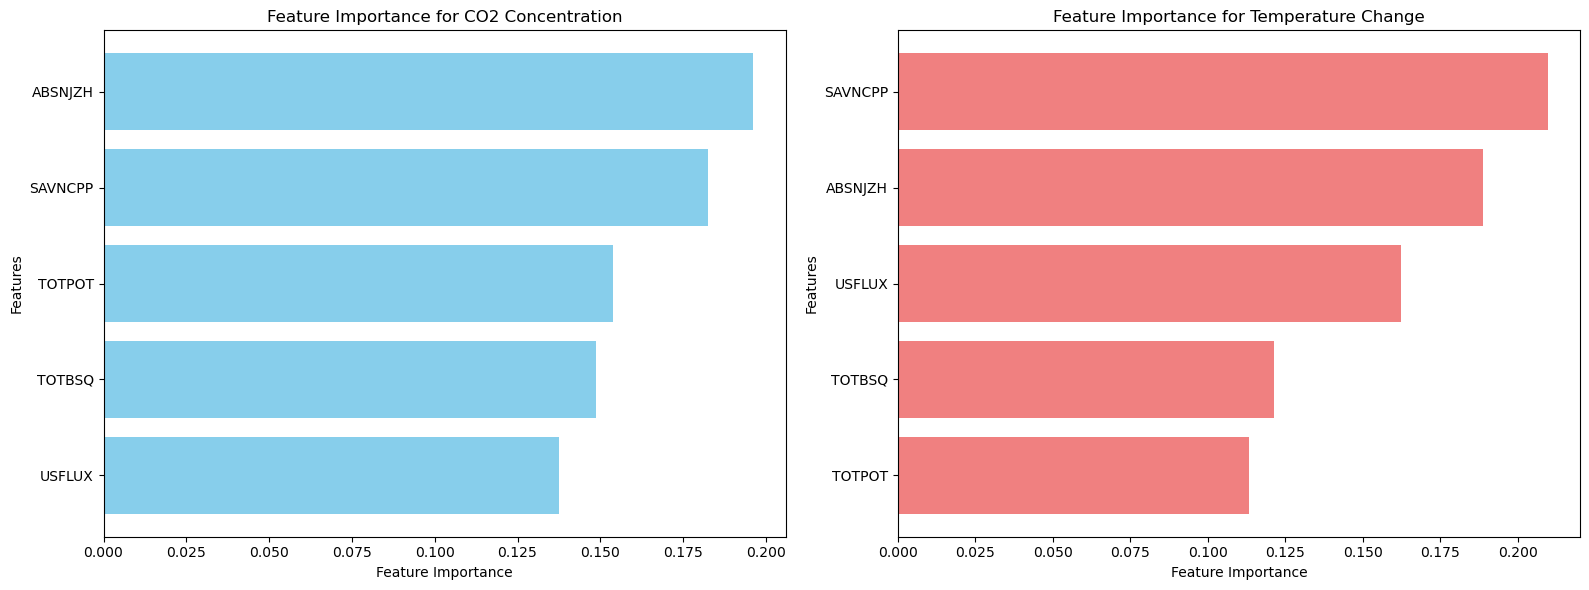

In [12]:
# Define the number of top features to plot
num_top_features = 5

# Extract top features and their importance values for CO2 concentration
top_features_co2 = importance_df_co2.iloc[:num_top_features]['Feature']
top_importance_co2 = importance_df_co2.iloc[:num_top_features]['Importance']

# Extract top features and their importance values for Temperature change
top_features_temp = importance_df_temp.iloc[:num_top_features]['Feature']
top_importance_temp = importance_df_temp.iloc[:num_top_features]['Importance']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot feature importance for CO2 concentration
axs[0].barh(top_features_co2, top_importance_co2, color='skyblue')
axs[0].set_xlabel('Feature Importance')
axs[0].set_ylabel('Features')
axs[0].set_title('Feature Importance for CO2 Concentration')
axs[0].invert_yaxis()  # Invert y-axis to display highest importance at the top

# Plot feature importance for Temperature change
axs[1].barh(top_features_temp, top_importance_temp, color='lightcoral')
axs[1].set_xlabel('Feature Importance')
axs[1].set_ylabel('Features')
axs[1].set_title('Feature Importance for Temperature Change')
axs[1].invert_yaxis()  # Invert y-axis to display highest importance at the top

plt.tight_layout()

plt.savefig('/home/jovyan/work/Test/feature_importance_plot.png')

plt.show()

### Generate subset of merged data with selected features

In [13]:
top_features_co2 = importance_df_co2['Feature'].head(5).tolist()
top_features_temp = importance_df_temp['Feature'].head(5).tolist()
top_features = list(set(top_features_co2 + top_features_temp))
features_of_interesst = top_features + ['CO2_Concentration_PPM', 'Temp_change']
subset_merged_data = merged_data[features_of_interesst]

In [14]:
features_of_interesst

['USFLUX',
 'TOTBSQ',
 'TOTPOT',
 'SAVNCPP',
 'ABSNJZH',
 'CO2_Concentration_PPM',
 'Temp_change']

### Performe Hypothesis Testing (t-tests)

In [15]:
# Define significance level
alpha = 0.05

# Conduct t-tests for CO2 concentration
co2_p_values = {}
for feature in top_features_co2:
    feature_values = subset_merged_data[feature]
    t_stat, p_value = ttest_ind(feature_values, subset_merged_data['CO2_Concentration_PPM'])
    co2_p_values[feature] = p_value

# Conduct t-tests for temperature change
temp_p_values = {}
for feature in top_features_temp:
    feature_values = subset_merged_data[feature]
    t_stat, p_value = ttest_ind(feature_values, subset_merged_data['Temp_change'])
    temp_p_values[feature] = p_value

# Print p-values
print("P-values for CO2 Concentration:")
print(co2_p_values)
print("\nP-values for Temperature Change:")
print(temp_p_values)

# Check for significance
significant_co2_features = [feature for feature, p_value in co2_p_values.items() if p_value < alpha]
significant_temp_features = [feature for feature, p_value in temp_p_values.items() if p_value < alpha]

print("\nSignificant features for CO2 Concentration:", significant_co2_features)
print("Significant features for Temperature Change:", significant_temp_features)


P-values for CO2 Concentration:
{'ABSNJZH': 1.2166759190327517e-17, 'SAVNCPP': 2.7088924013845084e-21, 'TOTPOT': 1.0892397616412513e-15, 'TOTBSQ': 1.1409257673754999e-25, 'USFLUX': 2.846167688737773e-26}

P-values for Temperature Change:
{'SAVNCPP': 2.7088923852165315e-21, 'ABSNJZH': 3.513151800389356e-15, 'USFLUX': 2.846167688737773e-26, 'TOTBSQ': 1.140924080658377e-25, 'TOTPOT': 1.0892397616412513e-15}

Significant features for CO2 Concentration: ['ABSNJZH', 'SAVNCPP', 'TOTPOT', 'TOTBSQ', 'USFLUX']
Significant features for Temperature Change: ['SAVNCPP', 'ABSNJZH', 'USFLUX', 'TOTBSQ', 'TOTPOT']


### Check for Normality & Homogeneity of Variances

In [16]:
# Shapiro-Wilk test for normality
def test_normality(data):
    for column in data.columns:
        stat, p = stats.shapiro(data[column])
        print(f'Shapiro-Wilk test for normality (p-value) for column {column}: {p:.4f}')
        if p > 0.05:
            print(f'{column} is normally distributed')
        else:
            print(f'{column} is not normally distributed')

# Levene's test for homogeneity of variances
def test_homogeneity(data):
    stat, p = stats.levene(*[data[column] for column in data.columns])
    print(f'Levene\'s test for homogeneity of variances (p-value): {p:.4f}')
    if p > 0.05:
        print('Homogeneity of variances is satisfied')
    else:
        print('Homogeneity of variances is not satisfied')


In [17]:
test_normality(subset_merged_data)
test_homogeneity(subset_merged_data)

Shapiro-Wilk test for normality (p-value) for column USFLUX: 0.0000
USFLUX is not normally distributed
Shapiro-Wilk test for normality (p-value) for column TOTBSQ: 0.0000
TOTBSQ is not normally distributed
Shapiro-Wilk test for normality (p-value) for column TOTPOT: 0.0000
TOTPOT is not normally distributed
Shapiro-Wilk test for normality (p-value) for column SAVNCPP: 0.0000
SAVNCPP is not normally distributed
Shapiro-Wilk test for normality (p-value) for column ABSNJZH: 0.0000
ABSNJZH is not normally distributed
Shapiro-Wilk test for normality (p-value) for column CO2_Concentration_PPM: 0.0000
CO2_Concentration_PPM is not normally distributed
Shapiro-Wilk test for normality (p-value) for column Temp_change: 0.0000
Temp_change is not normally distributed
Levene's test for homogeneity of variances (p-value): 0.0000
Homogeneity of variances is not satisfied


### Calculate & Visualize correlation coefficients

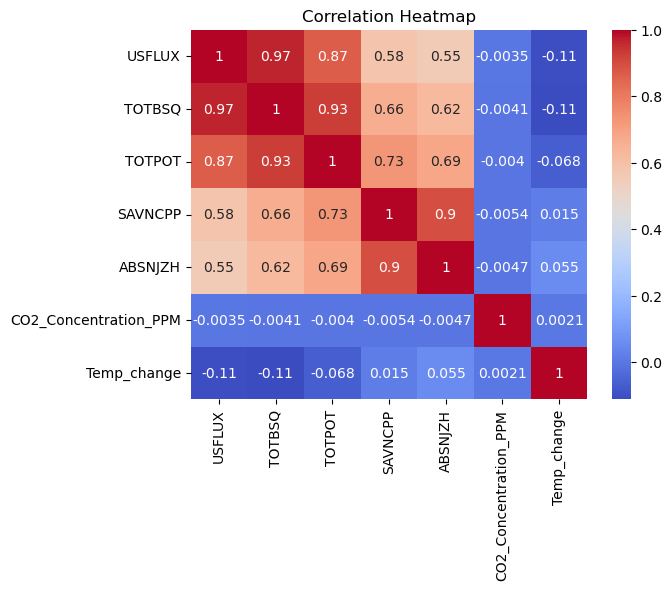

In [18]:
correlation_matrix = subset_merged_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Visualize Autocorrelations of Temperature Change and CO2 Concentration

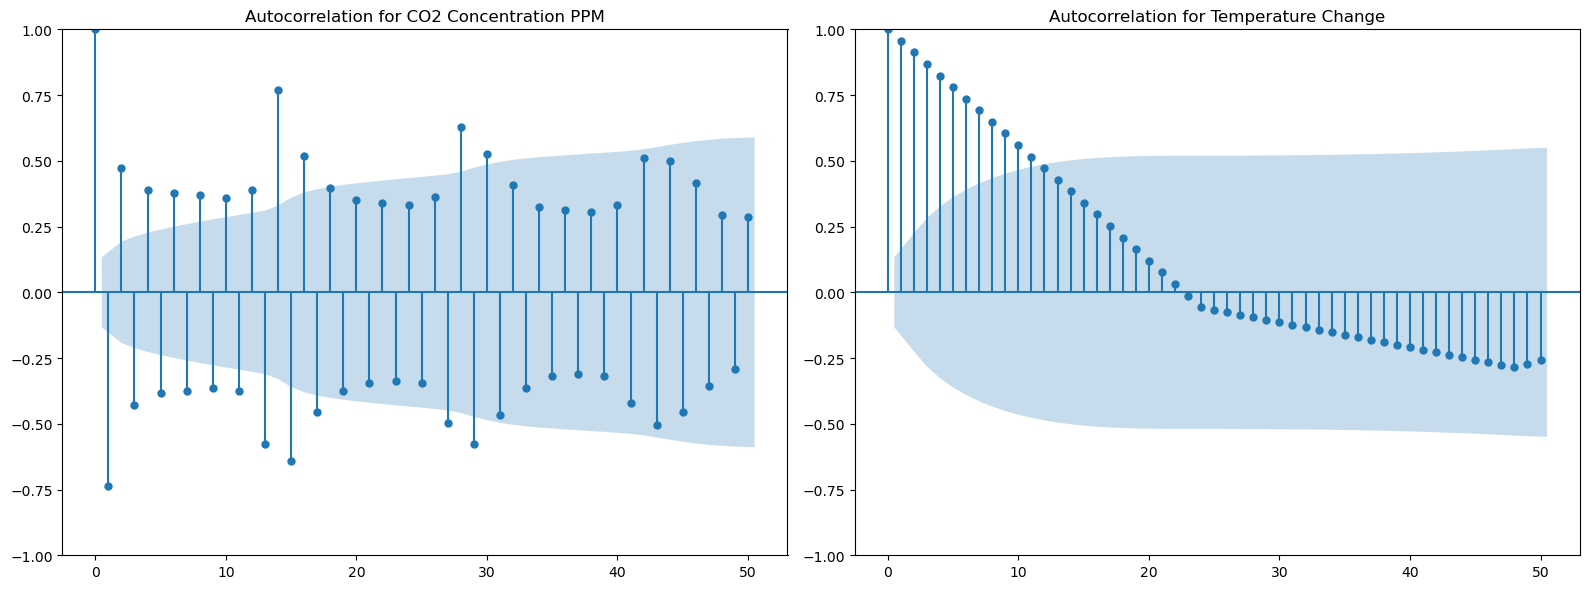

In [19]:


# Create a figure with subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot autocorrelation for CO2_Concentration_PPM
plot_acf(subset_merged_data['CO2_Concentration_PPM'], ax=axes[0], lags=50)
axes[0].set_title('Autocorrelation for CO2 Concentration PPM')

# Plot autocorrelation for Temp_change
plot_acf(subset_merged_data['Temp_change'], ax=axes[1], lags=50)
axes[1].set_title('Autocorrelation for Temperature Change')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot
fig.savefig('/home/jovyan/work/Test/autocorrelation_plots.png')